In [38]:
import numpy as np
import matplotlib.pyplot as plt
import mujoco 
# import mujoco.viewer
import time
import desired_kinematic
# import compute_activation as ca
# import force_length_velocity_functions as flv
import get_activations
import plot_functions
import os 


### 1. Compute activations for static posture

In [270]:

path_to_model = "../Working_Folder/tendon_quadruped_ws_inair.xml"
model = mujoco.MjModel.from_xml_path(path_to_model)
data = mujoco.MjData(model)
n_muscles = model.nu
n_joints = model.nv


data.qpos[-8:] = [-0.179,0.0965,-0.179,0.0965,-0.179,0.0965,-0.179,0.0965]  # set the desired joint positions
data.qvel[-8:] = 0
data.qacc[-8:] = 0
F0 = np.ones(n_muscles) * 1000 

constrained_dofs = [2,3,4,5,6,7,8] 

mujoco.mj_inverse(model, data)

joint_torque = data.qfrc_inverse
actuator_moment_values = data.actuator_moment

moment_matrix = get_activations.fill_actuator_moments(n_muscles, n_joints, actuator_moment_values)
actuator_moments_transpose = moment_matrix.T

RT_leg = actuator_moments_transpose[constrained_dofs, :]     # only the rows for leg joints
tau_leg = joint_torque[constrained_dofs]           # only desired torques for leg joints

F_t = get_activations.solve_tendon_forces(RT_leg, tau_leg)



# print(f"Type of actuator_moments_transpose: {type(actuator_moments_transpose)}")
# print(f"Type of joint_torque: {type(joint_torque)}")
# print(f"Type of F0: {type(F0)}")

# F_t = get_activations.solve_tendon_forces(actuator_moments_transpose, joint_torque) #,F0) #,a_min=0.2, a_max=1.0)
# a_t = ca.invert_flv(F_t, FL_t, FV_t, FP_t, F0)

a_t = F_t / F0
# print(a_t)
# muscel_forces = F_t
activations  = np.clip(a_t, 0, 1)
# print(activations)



# Save activations to a file
# activation_file = f"activation_static_05_26.txt"
# duration_in_seconds = 10
# dt = 0.005

n_muscles = model.nu
n_steps = 2000
static_muscle_activations = np.zeros((n_steps, n_muscles))

    
# for m in range(n_muscles):
#     muscle_activations[:,m] = activations[m] * np.ones(n_steps)

# #  there are 4 legs with 3 muscles per leg, i want to set the activations of the leg muscles for example all first mscles of each leg will have same activation, second muscles of each  legs  i will manually set the activation as 0 2 3

for m in range(n_muscles):
    if m % 3 == 0:
        static_muscle_activations[:, m] = 0 *   np.ones(n_steps)  # first muscle of each leg
    elif m % 3 == 1:
        static_muscle_activations[:, m] = 0.4 * np.ones(n_steps)  # second muscle of each leg
    elif m % 3 == 2:
        static_muscle_activations[:, m] = 0.4 * np.ones(n_steps)  # third muscle of each leg

print(static_muscle_activations)


[[0.  0.4 0.4 ... 0.  0.4 0.4]
 [0.  0.4 0.4 ... 0.  0.4 0.4]
 [0.  0.4 0.4 ... 0.  0.4 0.4]
 ...
 [0.  0.4 0.4 ... 0.  0.4 0.4]
 [0.  0.4 0.4 ... 0.  0.4 0.4]
 [0.  0.4 0.4 ... 0.  0.4 0.4]]


In [269]:
timestep = model.opt.timestep
delay_duration = 3.0  # seconds
delay_steps = int(delay_duration / timestep)
duration  = static_muscle_activations.shape[0]
# muscle_activations[muscle_activations == 0] = 0.005
scaled_muscle_activations = static_muscle_activations

path_to_model = "../Working_Folder/tendon_quadruped_ws_onground.xml"
model = mujoco.MjModel.from_xml_path(path_to_model)
data = mujoco.MjData(model)

with mujoco.viewer.launch_passive(model, data, show_left_ui=False, show_right_ui=True) as viewer:
        
    if model.ncam > 0:
        viewer.cam.type = mujoco.mjtCamera.mjCAMERA_FIXED
        viewer.cam.fixedcamid = 0
        mujoco.mj_resetData(model, data)


    idx = 0

    while viewer.is_running():
        step_start = time.time()

        if idx < delay_steps:
            data.ctrl[:] = 0.0
        else:
            data.ctrl[:] = scaled_muscle_activations[idx - delay_steps,:]
      
        mujoco.mj_step(model, data)

        with viewer.lock():
            viewer.opt.flags[mujoco.mjtVisFlag.mjVIS_CONTACTPOINT] = int(data.time)
                
        viewer.sync()

        time_until_next_step = model.opt.timestep - (time.time() - step_start)
        if time_until_next_step > 0:
            time.sleep(time_until_next_step)

        idx += 1
        if idx - delay_steps >= duration:
            break


### 2. Compute muscle activations for dynamics postures

In [ ]:

path_to_model = "../Working_Folder/tendon_quadruped_ws_inair.xml"

activation_folder = "../activation_data_files" 

for omega in np.round(np.arange(0.01, 1.21, 0.01),2):  # Increment omega from 0.1 to 1.2 (inclusive)
    try: 
        activation_file, desired_qpos, desired_qvel, desired_qacc = get_activations.compute_and_save_activations(
            path_to_model, 
            omega, 
            dt=0.005, 
            duration_in_seconds=10,
            activation_folder=activation_folder)

        muscle_activations = np.loadtxt(activation_file)
        print(f"Simulated omega: {omega}, Activation file: {activation_file}")

    except Exception as e:
        print(f"An error occurred while simulating omega {omega}: {e}")
        continue


#### 2.1 Run feedforward simulation of quadruped in air using computed activations

In [ ]:
path_to_model = "../Working_Folder/tendon_quadruped_ws_onground.xml"
activation_folder = "../activation_data_files" 

model = mujoco.MjModel.from_xml_path(path_to_model)
data = mujoco.MjData(model)

omega = 1.0
activation_file = f"{activation_folder}/activation_{omega}.txt"

dynamic_muscle_activations = (np.loadtxt(activation_file)) + static_muscle_activations

n_steps = dynamic_muscle_activations.shape[0]
num_joints = len(model.dof_jntid)
attempted_qpos = np.zeros((n_steps, num_joints))
attempted_qvel = np.zeros((n_steps, num_joints))
attempted_qacc = np.zeros((n_steps, num_joints))
muscle_velocities = np.zeros((n_steps, model.nu))
muscle_lengths = np.zeros((n_steps, model.nu))

timestep = model.opt.timestep
delay_duration = 5.0  # seconds
delay_steps = int(delay_duration / timestep)
duration  = dynamic_muscle_activations.shape[0]

with mujoco.viewer.launch_passive(model, data, show_left_ui=False, show_right_ui=True) as viewer:
        
    if model.ncam > 0:
        viewer.cam.type = mujoco.mjtCamera.mjCAMERA_FIXED
        viewer.cam.fixedcamid = 0
        mujoco.mj_resetData(model, data)

        
    idx = 0
    while viewer.is_running():
        step_start = time.time()

        if idx < delay_steps:
            data.ctrl[:] = 0.0
            data.qpos[:] = [0,-0.04,-0.179,0.0965,-0.179,0.0965,-0.179,0.0965,-0.179,0.0965] 
            data.qvel[:] = 0.0
        else:
            data.ctrl[:] = dynamic_muscle_activations[idx - delay_steps,:]
      
        mujoco.mj_step(model, data)
        attempted_qpos[idx,:] = data.qpos
        attempted_qvel[idx,:] = data.qvel
        attempted_qacc[idx,:] = data.qacc
        muscle_velocities[idx,:] = data.actuator_velocity
        muscle_lengths[idx,:] = data.actuator_length

        with viewer.lock():
            viewer.opt.flags[mujoco.mjtVisFlag.mjVIS_CONTACTPOINT] = int(data.time)
            
        viewer.sync()

        time_until_next_step = model.opt.timestep - (time.time() - step_start)
        if time_until_next_step > 0:
            time.sleep(time_until_next_step)

        idx += 1
        if idx - delay_steps >= duration:
            break

IndexError: index 2000 is out of bounds for axis 0 with size 2000

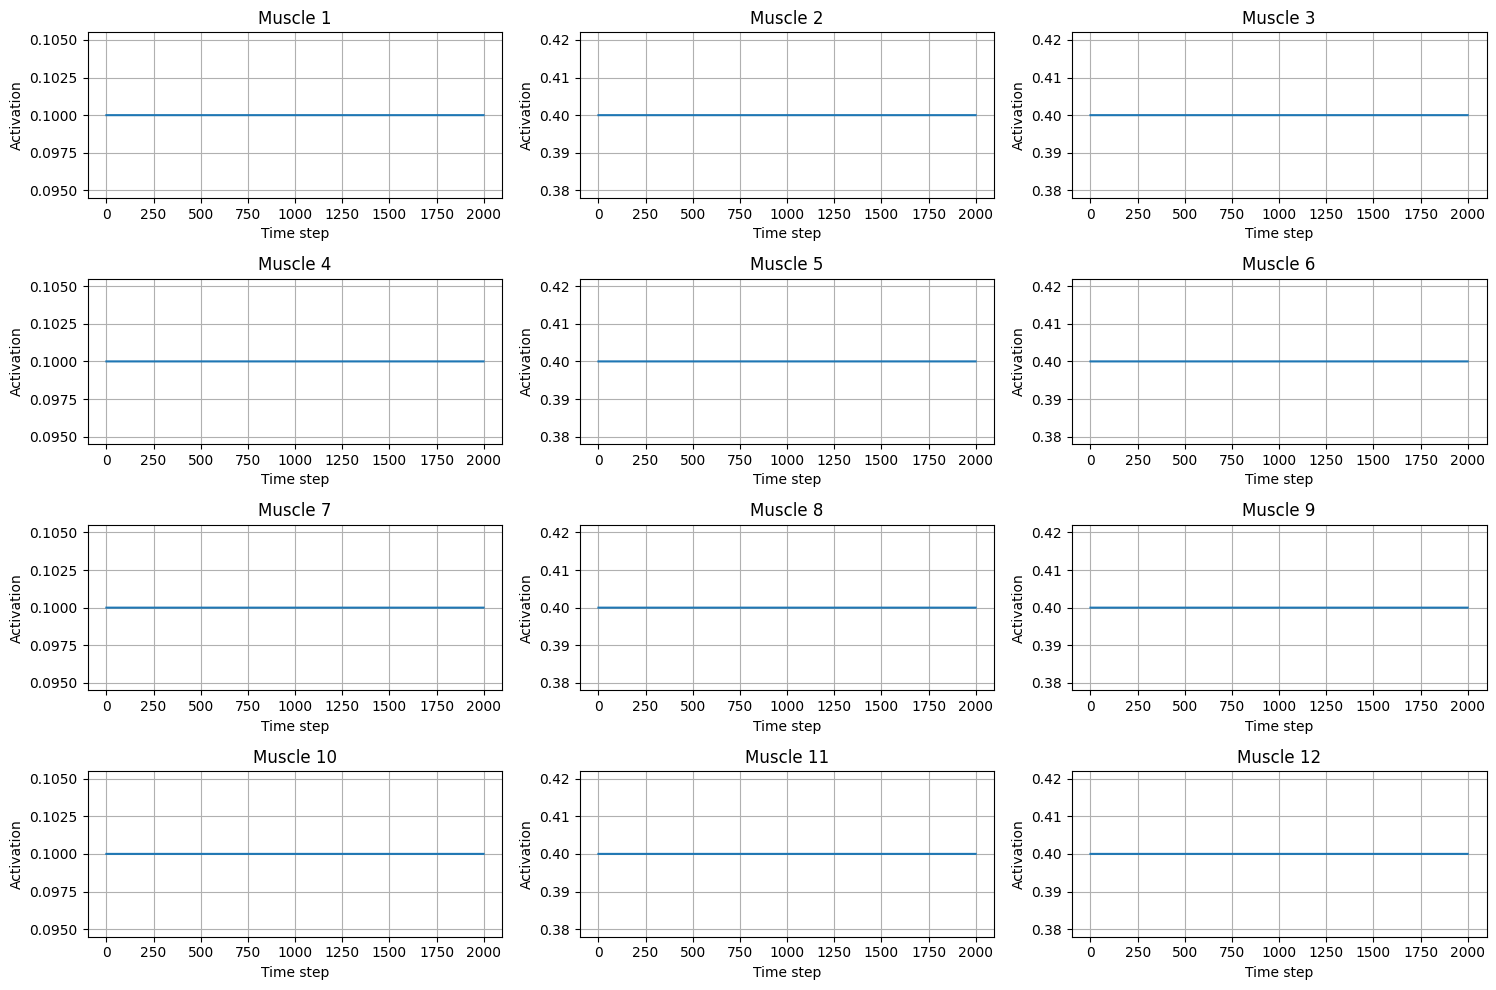

In [61]:
plot_functions.plot_muscle_activations(muscle_activations)

In [ ]:
plot_functions.plot_muscle_activations(muscle_lengths)

In [ ]:

plot_functions.plot_muscle_activations(muscle_velocities)

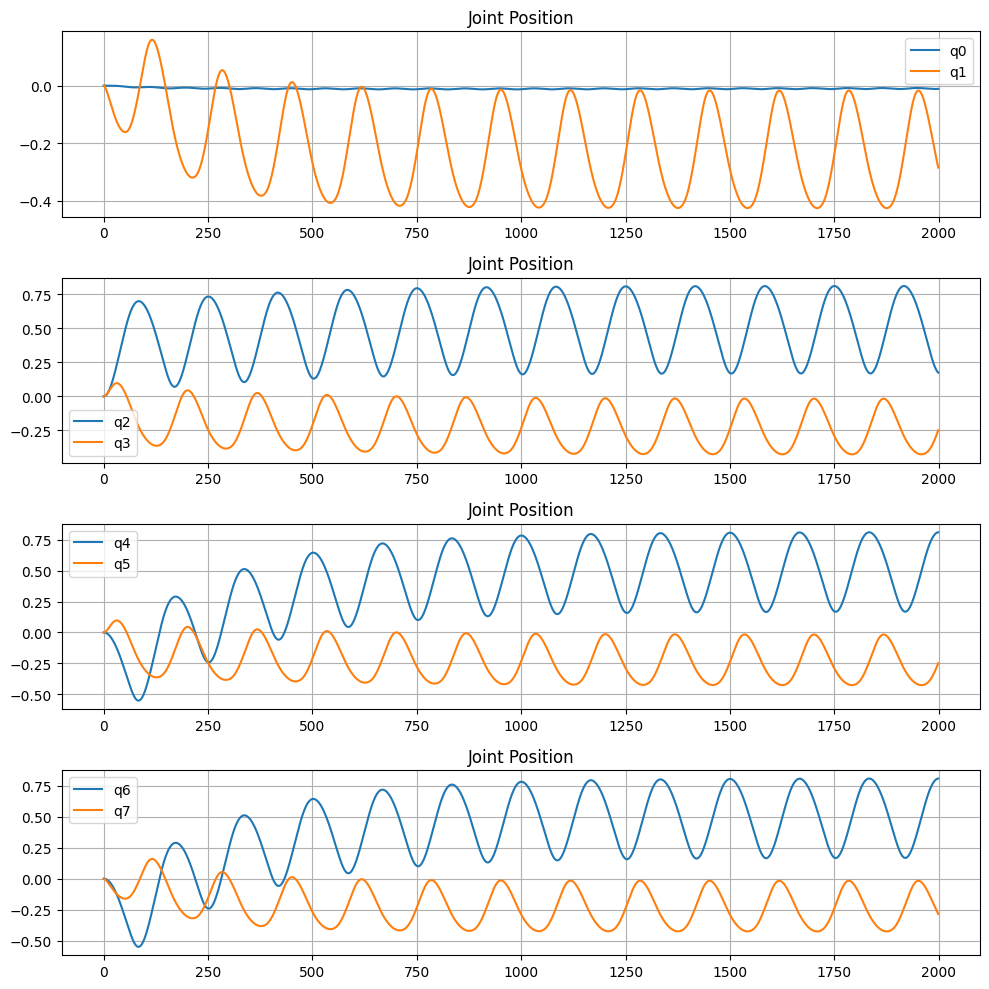

<Figure size 640x480 with 0 Axes>

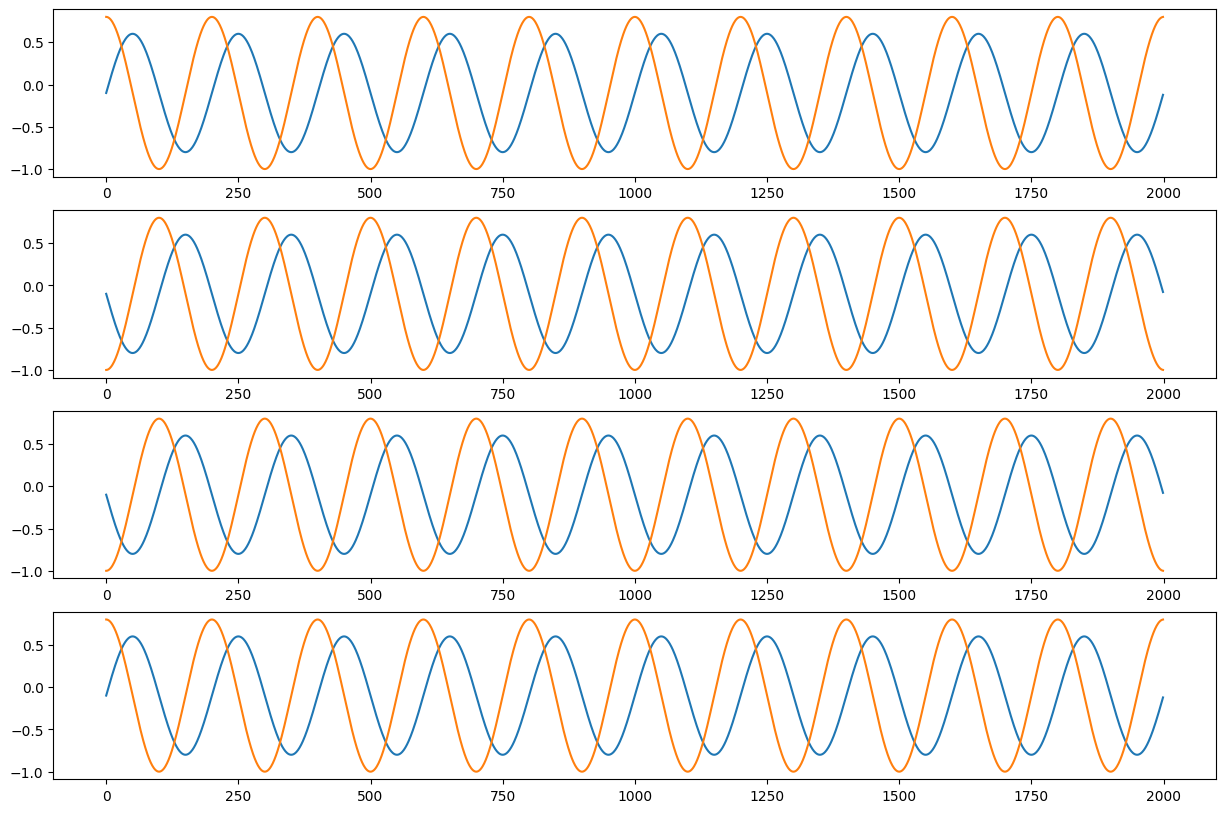

In [51]:
plot_functions.plot_joint_state(attempted_qpos)
attempt_kinematics_RB, attempt_kinematics_RF, attempt_kinematics_LB, attempt_kinematics_LF = desired_kinematic.create_cyclical_movements_fcn(omega=1, attempt_length=10, dt=0.005)
plt.figure()
# create a four by 1 plot, on same axis suplot each leg's kinematics, time is the x axis, y axis is the joint angles
fig, axs = plt.subplots(4, 1, figsize=(15, 10))
axs[0].plot(attempt_kinematics_RB[:, 0], label='RB Hip')
axs[0].plot(attempt_kinematics_RB[:, 1], label='RB Knee')

axs[1].plot(attempt_kinematics_RF[:, 0], label='RF Hip')
axs[1].plot(attempt_kinematics_RF[:, 1], label='RF Knee')

axs[2].plot(attempt_kinematics_LB[:, 0], label='LB Hip')
axs[2].plot(attempt_kinematics_LB[:, 1], label='LB Knee')

axs[3].plot(attempt_kinematics_LF[:, 0], label='LF Hip')
axs[3].plot(attempt_kinematics_LF[:, 1], label='LF Knee')




In [52]:
print(attempt_kinematics_RB[:,0])
print(attempt_kinematics_RB[:,1])

print(attempt_kinematics_RF[:,0])
print(attempt_kinematics_RF[:,1])

print(attempt_kinematics_LB[:,0])
print(attempt_kinematics_LB[:,1])

print(attempt_kinematics_LF[:,0])
print(attempt_kinematics_LF[:,1])

[-0.1        -0.07801247 -0.05604664 ... -0.16587582 -0.14395336
 -0.12198753]
[0.8        0.7995559  0.79822406 ... 0.79600577 0.79822406 0.7995559 ]
[-0.1        -0.12198753 -0.14395336 ... -0.03412418 -0.05604664
 -0.07801247]
[-1.         -0.9995559  -0.99822406 ... -0.99600577 -0.99822406
 -0.9995559 ]
[-0.1        -0.12198753 -0.14395336 ... -0.03412418 -0.05604664
 -0.07801247]
[-1.         -0.9995559  -0.99822406 ... -0.99600577 -0.99822406
 -0.9995559 ]
[-0.1        -0.07801247 -0.05604664 ... -0.16587582 -0.14395336
 -0.12198753]
[0.8        0.7995559  0.79822406 ... 0.79600577 0.79822406 0.7995559 ]


### 3. Run feedforward simulation with quadruped on the ground model

In [ ]:
path_to_model = "../Working_Folder/tendon_quadruped_ws_onground.xml"
activation_folder = "../activation_data_files" 

model = mujoco.MjModel.from_xml_path(path_to_model)
data = mujoco.MjData(model)

omega = 1.2
activation_file = f"{activation_folder}/activation_{omega}.txt"
muscle_activations = np.loadtxt(activation_file)

n_steps = muscle_activations.shape[0]
num_joints = len(model.dof_jntid)
attempted_qpos = np.zeros((n_steps, num_joints))
attempted_qvel = np.zeros((n_steps, num_joints))
attempted_qacc = np.zeros((n_steps, num_joints))
idx = 0
wait_time = 0.5


idx = 0
wait_time = 0.5

muscle_velocities = np.zeros((n_steps, model.nu))
muscle_lengths = np.zeros((n_steps, model.nu))

with mujoco.viewer.launch_passive(model, data, show_left_ui=False, show_right_ui=True) as viewer:

    if model.ncam > 0:
        viewer.cam.type = mujoco.mjtCamera.mjCAMERA_FIXED
        viewer.cam.fixedcamid = 0
        mujoco.mj_resetData(model, data)

    for idx in range(n_steps):
        step_start = time.time()
        data.ctrl[:] = muscle_activations[idx,:] * 10
        mujoco.mj_step(model, data)
        attempted_qpos[idx,:] = data.qpos
        attempted_qvel[idx,:] = data.qvel
        attempted_qacc[idx,:] = data.qacc
        muscle_velocities[idx,:] = data.actuator_velocity
        muscle_lengths[idx,:] = data.actuator_length

        with viewer.lock():
            viewer.opt.flags[mujoco.mjtVisFlag.mjVIS_CONTACTPOINT] = int(data.time)
            
        viewer.sync()
    

        time_until_next_step = model.opt.timestep - (time.time() - step_start)
        if time_until_next_step > 0:
            time.sleep(time_until_next_step)

        # save muscle velocity


In [ ]:
plot_functions.plot_muscle_activations(muscle_lengths)

In [ ]:
# plot muscle velocity

plot_functions.plot_muscle_activations(muscle_velocities)

## Closed-loop simulation with spindle_feedback

### 4.1 Beta-MN : Skeleto-fusimotor system

In [12]:
path_to_model = "../Working_Folder/tendon_quadruped_ws_onground.xml"
activation_folder = "../activation_data_files" 

model = mujoco.MjModel.from_xml_path(path_to_model)
data = mujoco.MjData(model)

omega = 1.2
activation_file = f"{activation_folder}/activation_{omega}.txt"
muscle_activations = np.loadtxt(activation_file)

n_steps = muscle_activations.shape[0]
num_joints = len(model.dof_jntid)
attempted_qpos = np.zeros((n_steps, num_joints))
attempted_qvel = np.zeros((n_steps, num_joints))
attempted_qacc = np.zeros((n_steps, num_joints))


muscle_velocities = np.zeros((n_steps, model.nu))
muscle_lengths = np.zeros((n_steps, model.nu))

sensor_names = ['rb_sensor','rf_sensor','lb_sensor','lf_sensor']
leg_muscle_ids = {
    'rb_sensor': [0, 1, 2],  # Right Back leg muscles
    'rf_sensor': [3, 4, 5],  # Right Front leg muscles
    'lb_sensor': [6, 7, 8],  # Left Back leg muscles
    'lf_sensor': [9, 10, 11]  # Left Front leg muscles
}

k_ia = 1
k_alpha = 10.0
num_muscles = model.nu 
Ia_per_leg = np.zeros(num_muscles)  


with mujoco.viewer.launch_passive(model, data, show_left_ui=False, show_right_ui=True) as viewer:

    if model.ncam > 0:
        viewer.cam.type = mujoco.mjtCamera.mjCAMERA_FIXED
        viewer.cam.fixedcamid = 0
        mujoco.mj_resetData(model, data)

    for idx in range(n_steps):
        step_start = time.time()


        if k_ia!= 0:

            beta_drive = (muscle_activations[idx, :] * k_alpha + Ia_per_leg) * k_ia

            for sensor_name in sensor_names:
                contact_force = data.sensordata[sensor_names.index(sensor_name)] > 0.0  # Check for contact

                if contact_force:  # If there is contact for this leg
                    muscle_ids = leg_muscle_ids[sensor_name]  # Get the muscle IDs for this leg

                    for muscle_id in muscle_ids:
                        muscle_velocity = data.actuator_velocity[muscle_id]  # Get the velocity of the muscle

                        if muscle_velocity > 0:  # If the muscle is lengthening
                            Ia_per_leg[muscle_id] = beta_drive[muscle_id] * muscle_velocity  # Compute Ia feedback
                        else:  # If the muscle is shortening
                            Ia_per_leg[muscle_id] = 0  # No Ia feedback
        else:
            beta_drive = muscle_activations[idx, :] * k_alpha

        data.ctrl[:] = beta_drive
        mujoco.mj_step(model,data)
        
        
        attempted_qpos[idx,:] = data.qpos
        attempted_qvel[idx,:] = data.qvel
        attempted_qacc[idx,:] = data.qacc
        muscle_velocities[idx,:] = data.actuator_velocity
        muscle_lengths[idx,:] = data.actuator_length

        with viewer.lock():
            viewer.opt.flags[mujoco.mjtVisFlag.mjVIS_CONTACTPOINT] = int(data.time)
            
        viewer.sync()
    

        time_until_next_step = model.opt.timestep - (time.time() - step_start)
        if time_until_next_step > 0:
            time.sleep(time_until_next_step)

        # save muscle velocity

### 4.2 Fusimotor system with alpha-to-gamma collateral

In [314]:
path_to_model = "../Working_Folder/tendon_quadruped_ws_onground.xml"
activation_folder = "../activation_data_files" 

model = mujoco.MjModel.from_xml_path(path_to_model)
data = mujoco.MjData(model)

omega = 1.2
activation_file = f"{activation_folder}/activation_{omega}.txt"
muscle_activations = np.loadtxt(activation_file)

n_steps = muscle_activations.shape[0]
num_joints = len(model.dof_jntid)
attempted_qpos = np.zeros((n_steps, num_joints))
attempted_qvel = np.zeros((n_steps, num_joints))
attempted_qacc = np.zeros((n_steps, num_joints))
idx = 0
wait_time = 0.5


idx = 0
wait_time = 1.2

muscle_velocities = np.zeros((n_steps, model.nu))
muscle_lengths = np.zeros((n_steps, model.nu))

sensor_names = ['rb_sensor','rf_sensor','lb_sensor','lf_sensor']
leg_muscle_ids = {
    'rb_sensor': [0, 1, 2],  # Right Back leg muscles
    'rf_sensor': [3, 4, 5],  # Right Front leg muscles
    'lb_sensor': [6, 7, 8],  # Left Back leg muscles
    'lf_sensor': [9, 10, 11]  # Left Front leg muscles
}

k_ia = 0.0
k_alpha = 50
num_muscles = model.nu 
Ia_per_leg = np.zeros(num_muscles)  


with mujoco.viewer.launch_passive(model, data, show_left_ui=False, show_right_ui=True) as viewer:

    if model.ncam > 0:
        viewer.cam.type = mujoco.mjtCamera.mjCAMERA_FIXED
        viewer.cam.fixedcamid = 0
        mujoco.mj_resetData(model, data)

    for idx in range(n_steps):
        step_start = time.time()


        if k_ia!= 0:

            alpha_drive = muscle_activations[idx, :] * k_alpha + Ia_per_leg

            for sensor_name in sensor_names:
                contact_force = data.sensordata[sensor_names.index(sensor_name)] > 0.0  # Check for contact

                if contact_force:  # If there is contact for this leg
                    muscle_ids = leg_muscle_ids[sensor_name]  # Get the muscle IDs for this leg

                    for muscle_id in muscle_ids:
                        muscle_velocity = data.actuator_velocity[muscle_id]  # Get the velocity of the muscle

                        if muscle_velocity > 0:  # If the muscle is lengthening
                            Ia_per_leg[muscle_id] = (alpha_drive[muscle_id] * k_ia) * muscle_velocity  # Compute Ia feedback
                            # Ia_per_leg[muscle_id] = (k_ia) * muscle_velocity
                        else:  # If the muscle is shortening
                            Ia_per_leg[muscle_id] = 0  # No Ia feedback
        else:
            alpha_drive = muscle_activations[idx, :] *  k_alpha

        data.ctrl[:] = alpha_drive
        mujoco.mj_step(model,data)
        
        
        attempted_qpos[idx,:] = data.qpos
        attempted_qvel[idx,:] = data.qvel
        attempted_qacc[idx,:] = data.qacc
        muscle_velocities[idx,:] = data.actuator_velocity
        muscle_lengths[idx,:] = data.actuator_length

        with viewer.lock():
            viewer.opt.flags[mujoco.mjtVisFlag.mjVIS_CONTACTPOINT] = int(data.time)
            
        viewer.sync()
    

        time_until_next_step = model.opt.timestep - (time.time() - step_start)
        if time_until_next_step > 0:
            time.sleep(time_until_next_step)


Part B: REMOVE CONTACT DETECTION & ADD SPINDLE FEEDBACK WHILE IN AIR